<img src="https://www.thefandomentals.com/wp-content/uploads/2016/12/friends-seinfeld-cover.jpg" width="1500" height="450" />


# ***Assignment III - December 2022***
 *Ido Gazit, Rony Lupatin, Hemdat Lebel*

---
***Our goal is to  identify whether a line was taken from a Seinfeld episode or a Friends episode.***

## **Library Import**

In [16]:
# generals
import os
import pandas as pd
import numpy as np

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# model evalutation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# hide warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling2D, Dropout, BatchNormalization, Embedding
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer 

from keras import callbacks
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

from wordcloud import WordCloud 
from wordcloud import ImageColorGenerator
from urllib.request import urlopen
from PIL import Image

import random as python_random

Set random seeds to get reproducible results each training

In [17]:
np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

## **Data import**

In [18]:
train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

##**EDA & Preprocessing**

In [19]:
train_df.head()

,Dialogue,Character,Episode,Show,Dialogue_length
0,Hey.,joey,Season-07 Episode-13-The One Where Rosita Dies,Friends,1
1,(to Joey) Are you gonna be embarrassed going ...,phoebe,Season-10 Episode-04-The One With The Cake,Friends,13
2,"Me? No no no, you. You're gonna tell him. I'm ...",elaine,S03E22,Seinfeld,14
3,Alright you guys are off to party number one ...,chandler,Season-02 Episode-22-The One With the Two Parties,Friends,56
4,Am I? Or am I so sane that you just blew your ...,kramer,S05E12,Seinfeld,13


In [20]:
print('Shape of x_train is:', train_df.shape)
print('Shape of x_test is:', test_df.shape)

Shape of x_train is: (70405, 5)
Shape of x_test is: (4245, 5)


The classes distribution:

In [21]:
train_df['Show'].value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

Let's look at one Dialogue:

In [22]:
train_df['Dialogue'][250]

"You're really helping me out with this, buddy. Kids are gonna be so thrilled."

### Removing special characters
Before training the DL algorithms, we need to clean the data and preprocess it.<br>  Let's begin by cleaning the text and removing special characters:

In [23]:
from bs4 import BeautifulSoup
import re
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on Dialogue column of train_df
train_df['Dialogue'] = train_df['Dialogue'].apply(remove_special_characters)

# Apply function on Dialogue column of test_df
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)

In [24]:
train_df['Dialogue'][250]

'Youre really helping me out with this buddy Kids are gonna be so thrilled'

### Removing stop words

*Stop words* are words that are commonly used in a language but do not carry significant meaning and are usually removed from texts in order to improve the processing and analysis of the language.<br>
So we will continue by download all English stop words that NLTK library offers.

In [25]:
import nltk
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

# Removing the stopwords
from tqdm.notebook import tqdm
tqdm.pandas()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on Dialogue column of train_df
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(remove_stopwords)

# Apply function on Dialogue column of test_df
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [26]:
train_df['Dialogue'][250]

'Youre really helping buddy Kids gonna thrilled'

### Stemming
We'll continue by stemming the text.<br>
**Stemming** is a technique for reducing inflected (or sometimes derived) words to their word stem, base or root form, generally a written word form.

In [27]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    stemmed_words_list = []
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

# Apply function on Dialogue column of train_df
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(simple_stemmer)

# Apply function on Dialogue column of test_df
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)

  0%|          | 0/70405 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [28]:
train_df['Dialogue'][250]

'your realli help buddi kid gonna thrill'

## **Visualization**

Let's take a look at the most common words in each show <br>
Friends:

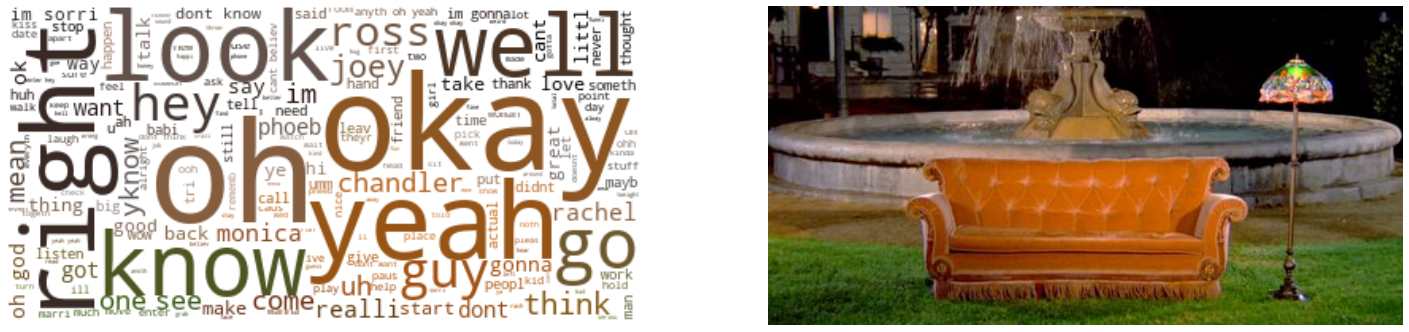

In [29]:
# Generate a word cloud image
mask = np.array(Image.open(urlopen("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/hb-friends-couch-1-1529331692.jpg?crop=1.00xw:1.00xh;0,0&resize=480:*")))
wordcloud = WordCloud(background_color="white",mode="RGBA").generate(' '.join(train_df[train_df['Show']=='Friends']['Dialogue'].tolist()))

# create coloring from image
image_colors = ImageColorGenerator(mask)

fig, axes = plt.subplots(1, 2, figsize=(25, 25))

axes[1].imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
axes[0].imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()

plt.show()

Seinfeld:

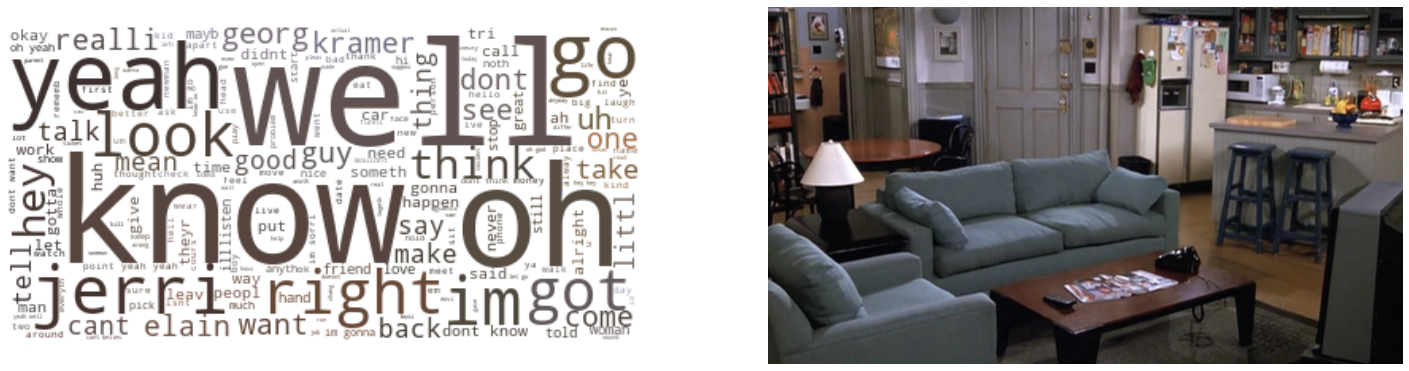

In [30]:
# Generate a word cloud image
mask = np.array(Image.open(urlopen("https://pbs.twimg.com/media/EUepxnbXkAU3LBq.jpg:large")))
wordcloud = WordCloud(background_color="white",mode="RGBA").generate(' '.join(train_df[train_df['Show']=='Seinfeld']['Dialogue'].tolist()))

# create coloring from image
image_colors = ImageColorGenerator(mask)

fig, axes = plt.subplots(1, 2, figsize=(25, 25))

axes[1].imshow(mask, cmap=plt.cm.gray, interpolation="bilinear")
axes[0].imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
for ax in axes:
    ax.set_axis_off()

plt.show()

In [31]:
import plotly.express as px
fig = px.histogram(train_df, x='Character', template='plotly_white', title='Dialogue counts by character')
fig.update_xaxes(categoryorder='total descending').update_yaxes(title='Number of dialogue')
fig.show()

## **Train-test-valdiation split**
Finally, we'll split the training data into training vs validation:

In [32]:
# x & y split for train
x_train = train_df['Dialogue']
y_train = train_df['Show']

# x & y split for test
x_test = test_df['Dialogue']
y_test = test_df['Show']

# train - validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, test_size=0.06)

We chose 0.06 as the split ratio to keep the valdiation and testing sets the same size.

In [33]:
print('Shape of X_train is:', x_train.shape)
print('Shape of Y_train is:', y_train.shape)
print('Shape of X_test is:', x_test.shape)
print('Shape of Y_test is:', y_test.shape)
print('Shape of X_val is:', x_val.shape)
print('Shape of Y_val is:', y_val.shape)

Shape of X_train is: (66180,)
Shape of Y_train is: (66180,)
Shape of X_test is: (4245,)
Shape of Y_test is: (4245,)
Shape of X_val is: (4225,)
Shape of Y_val is: (4225,)


###Labeling
We need to convert the values of 'Friends' and 'Seinfeld' to ones and zeros:

In [34]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

## **Deep Learning Model**
Let's build a DL model for this problem. <br>
We're going to use Keras' tokenizer,<br> ***Tokenization*** is the process of breaking down a piece of text into smaller units called tokens, which can be words, punctuation marks, or other elements of the text. <br>
We will use the '*Tokenizer*' class to tokenize a piece of text and convert it into a sequence of integers, where each integer represents a unique word in the text:

In [35]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)

In [36]:
x_train[900]

'friend sleep togeth'

And convert to sequences:

In [37]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
x_test_dl = token.texts_to_sequences(x_test)

For example:

In [38]:
x_train_dl[1]

[64, 23, 170]

Calculating document lengths:

In [39]:
doc_len_list = [len(doc) for doc in x_train_dl]
max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(185, 0, 5.822771229978845)

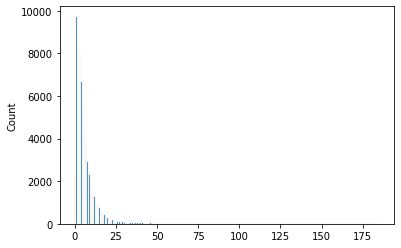

In [40]:
sns.histplot(doc_len_list)
plt.show()

zoom in:

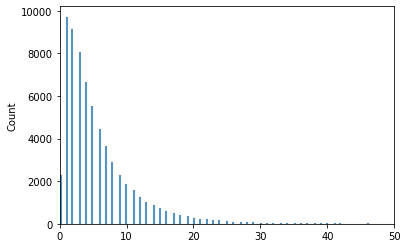

In [41]:
sns.histplot(doc_len_list)
plt.xlim(0, 50)
plt.show()

We want to make sure that all sequences have the same length. According to the distribution, 100 seems like a good value, for almost no sample is longer than 50:

In [42]:
from keras.utils import pad_sequences

max_words = 100

x_train_dl = pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = pad_sequences(x_test_dl, maxlen=max_words)

Now every sample can be a 100 words long (padded if needed):

In [43]:
x_train_dl.shape

(66180, 100)

Let's check out the size of our whole vocabulary:

In [44]:
total_words = len(token.word_index) + 1 
total_words

17135

Our architecture:

In [45]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=32, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           548320    
                                                                 
 conv1d (Conv1D)             (None, 100, 8)            776       
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                51264     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 600,425
Trainable params: 600,425
Non-trai

In [46]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
1035/1035 [==============================] - 12s 5ms/step - loss: 0.5648 - accuracy: 0.6792 - val_loss: 0.5020 - val_accuracy: 0.7356
Epoch 2/5
1035/1035 [==============================] - 5s 5ms/step - loss: 0.4566 - accuracy: 0.7605 - val_loss: 0.4792 - val_accuracy: 0.7396
Epoch 3/5
1035/1035 [==============================] - 5s 5ms/step - loss: 0.4007 - accuracy: 0.7912 - val_loss: 0.4918 - val_accuracy: 0.7354
Epoch 4/5
1035/1035 [==============================] - 5s 5ms/step - loss: 0.3624 - accuracy: 0.8112 - val_loss: 0.5192 - val_accuracy: 0.7378
Epoch 5/5
1035/1035 [==============================] - 5s 5ms/step - loss: 0.3311 - accuracy: 0.8261 - val_loss: 0.5708 - val_accuracy: 0.7262


Checking accuracy on the test set:

In [47]:
Y_pred = model.predict(x_test_dl)
Y_pred_labels = np.round(Y_pred)
print('Test Accuracy: ', accuracy_score(y_test, Y_pred_labels))

133/133 [==============================] - 0s 2ms/step
Test Accuracy:  0.8289752650176678


And the train:

In [48]:
Y_pred_train = model.predict(x_train_dl)
Y_pred_labels_train = np.round(Y_pred_train)
print('Train Accuracy' , accuracy_score(y_train,Y_pred_labels_train))

2069/2069 [==============================] - 3s 2ms/step
Train Accuracy 0.8523269870051375


### **Explore the results**

In [49]:
Character_lst = pd.unique(train_df['Character']) # list of the characters in the shows
acc_dict_char = {}

# now we'll match each show character with their prediction accuracy

for char in Character_lst:
  mask=np.where(test_df['Character'] == char)
  acc_dict_char[char]= accuracy_score(y_test[mask], Y_pred_labels[mask])

print("Accuracy dictionary per character:", acc_dict_char)

acc_dict_show = {}

for show in ['Friends', 'Seinfeld']:
  mask=np.where(test_df['Show'] == show)
  acc_dict_show[show]= accuracy_score(y_test[mask], Y_pred_labels[mask])

print("Accuracy dictionary per show:", acc_dict_show)

Accuracy dictionary per character: {'joey': 0.8665254237288136, 'phoebe': 0.883248730964467, 'elaine': 0.7636986301369864, 'chandler': 0.8467153284671532, 'kramer': 0.7702702702702703, 'monica': 0.8638743455497382, 'ross': 0.8757894736842106, 'george': 0.7531645569620253, 'rachel': 0.8658008658008658, 'jerry': 0.7836456558773425}
Accuracy dictionary per show: {'Friends': 0.8671032357473035, 'Seinfeld': 0.7689508793208005}


And let's see the individual confusion matrix for each character:

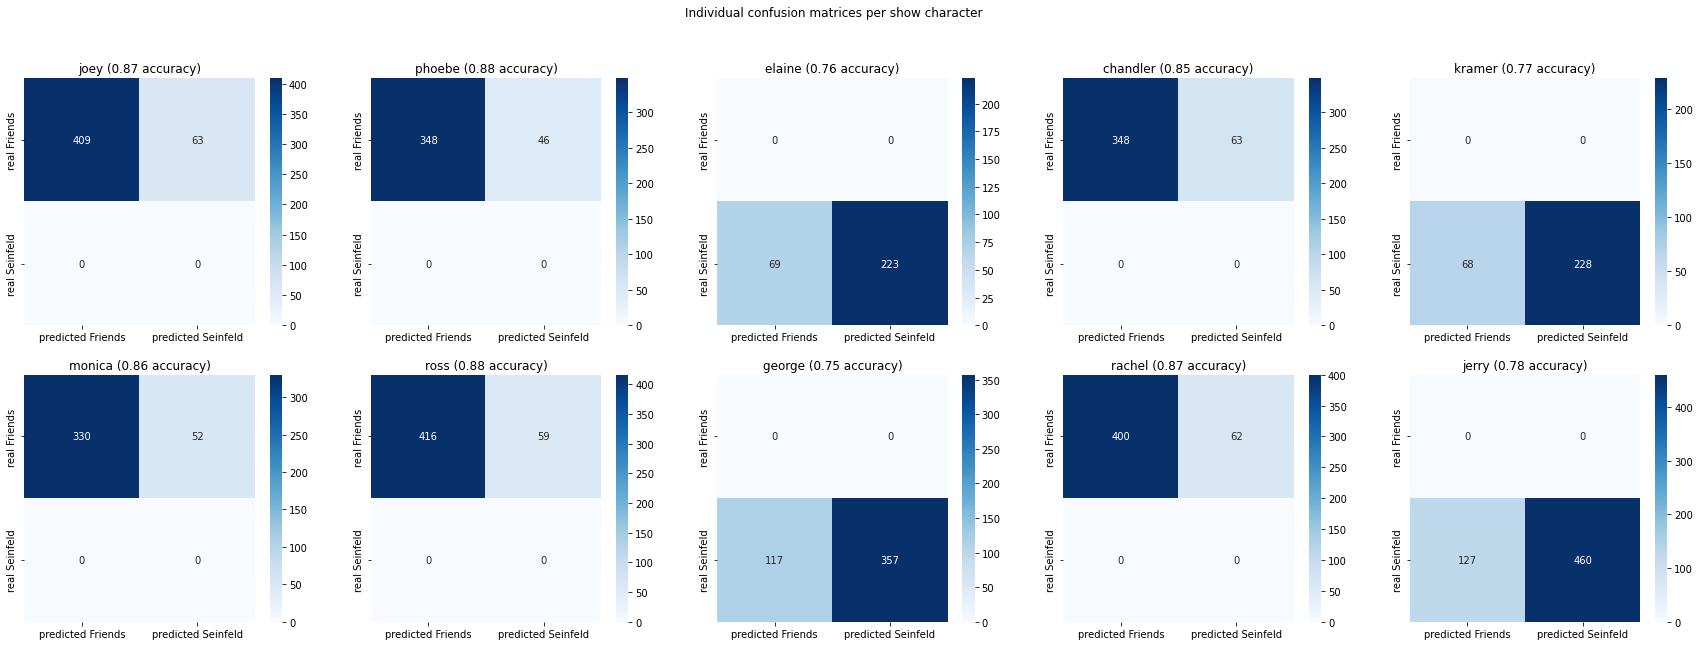

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 10), nrows=2, ncols=5)
fig.suptitle("Individual confusion matrices per show character")

# Iterate through the characters and plot the confusion matrices
for i in range(len(Character_lst)):
    char = Character_lst[i]
    mask = np.where(test_df['Character'] == char)
    cf_matrix = confusion_matrix(y_test[mask], Y_pred_labels[mask])
    sns.heatmap(cf_matrix,
                annot=True,
                fmt='g',
                cmap='Blues',
                xticklabels=["predicted Friends", "predicted Seinfeld"],
                yticklabels=["real Friends", "real Seinfeld"],
                ax=ax[i//5, i%5]).set_title(char + ' (' + str(acc_dict_char[char].round(2)) + ' accuracy)')

plt.show()

Hence, we can deduct that the model is generally more accurate predicting Friends dialogue lines, and that some characters are significantly more distinct than others (for example, within Friends, Phoebe is the most distinct, and within Seinfeld, Jerry would be the easiest to classify as Seinfeld. 

Given the time friends first aired (which is around the time Seinfeld was through), we can maybe guess that the way Seinfeld, the first modern American sitcom of some friends in NYC, was written, makes somewhat of a ground truth for creating a sitcom, and therefore it is harder to classify specifically as Seinfeld, for many other shows draw from their inventions. Nevertheless, this is only our humble suggestion. Hoochie mama.

And some more visualizations, by barplot and per show:

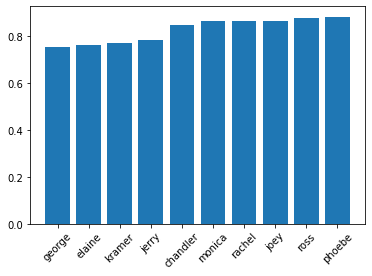

In [51]:
keys = acc_dict_char.keys()
values = acc_dict_char.values()
df = pd.DataFrame(dict(keys=keys,values=values))
df_sorted = df.sort_values('values')
plt.bar('keys', 'values', data=df_sorted)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

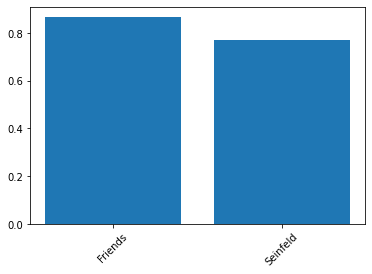

In [52]:
plt.bar(acc_dict_show.keys(), acc_dict_show.values())
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

## **Submission**

In [53]:
results = {'Test score (Accuracy)': ['0.833'],
           'Train score (Accuracy)': ['0.85'],
           'Number of trainable parameters': ['600,425'],
           'Number of layers': ['6'],
           'Regularization methods': ['Dropout'],
           'Number of epochs': ['5'],
           'Loss function': ['binary_crossentropy'],
           'Optimizer': ['adam'],
           'Embedding dimension' : ['32']
           }

df = pd.DataFrame(results)
df

,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer,Embedding dimension
0,0.833,0.85,"600,425",6,Dropout,5,binary_crossentropy,adam,32


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/MLDL advance course /Assignment III/
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))

<img src="https://i.pinimg.com/originals/40/98/31/409831dfb50f27ff8c4052d16f39f3fd.gif">